In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from model_prediction import Replicator
from pneumococcus_data import data_observation

In [2]:
# import Particle Swarm Optimization algorithm
from PSO_algo import Particle
from PSO_algo import PSO

### Description
The number of strains in Nepal is $n= 69$; and $\mu = 3.95$. We need to estimate the matrix $69 \times 69$ $\left(\alpha_{ij}\right)$ of Nepal. \
Since $\mu$ of Nepal is neither too large and nor too small, we estimate parameters such that the data observation (Nepal relative serotype prevalences) are: \
i) the equilibrium of the replicator dynamics, \
ii) a snapshot of the dynamics. \
In this program, we provide the process for case 
#### ii) a snapshot of the dynamics.
The process is similar to the parameter estimation for Iran's $\alpha_{ij}$'s: \
i) From $\alpha_{ij}$'s estimated in Brazil, Denmark, Mozambique, and Iran, in Nepal's $\alpha_{ij}$ matrix, we insert $1901$ values estimated before. \
ii) iii) Dyn: Calculate $\Lambda$ matrix and use PSO algorithm in range [−10, 10] to estimate 2860 remaining αij’s such that data observation is a snapshot of the dynamics. \
In PSO algorithm, we choose the range $\left[-10,10\right]$ for these $2860$ $\alpha_{ij}$'s. 

In [3]:
# data observation from 5 countries
Iran, Denmark, Brazil, Nepal, Mozambique = data_observation()

# import name of serotypes and their frequencies from Nepal
strain_number = len(Nepal.strain) # = 69
Nepal_strain = np.array(Nepal.strain)
Nepal_cases = np.array(Nepal.cases)

#ratio of single to co-colonization prevalence: mu value of Nepal
mu = 3.95

#import Brazil alpha & data
Brazil_alpha = np.loadtxt(open("Brazil_alpha.txt","rb"), delimiter=",", skiprows = 0)
Brazil_strain = np.array(Brazil.strain)
number_Brazil_strain = len(np.array(Brazil.strain))

#import Iran alpha & data
Iran_alpha = np.loadtxt(open("Iran_alpha.txt","rb"), delimiter=",", skiprows = 0)
Iran_strain = np.array(Iran.strain)

#import Denmark alpha & data
Denmark_alpha = np.loadtxt(open("Denmark_alpha.txt","rb"), delimiter=",", skiprows = 0)
Denmark_strain = np.array(Denmark.strain)

#import Mozambique alpha & data
Mozambique_alpha = np.loadtxt(open("Mozambique_alpha.txt","rb"), delimiter=",", skiprows = 0)
Mozambique_strain = np.array(Mozambique.strain)

In [4]:
# initiate matrix Mozambique_alpha
Nepal_alpha = np.ones((strain_number, strain_number))*50

#In Nepal alpha matrix, find the positions of alpha_ij already estimated before in Brazil, Denmark, Mozambique, Iran and fills with these values
for xN, strain_xN in enumerate(Nepal_strain):
    for yN, strain_yN in enumerate(Nepal_strain):
        #insert from Brazil
        find_xBrazil = np.where(Brazil_strain == strain_xN)
        index_xBrazil = find_xBrazil[0]

        find_yBrazil = np.where(Brazil_strain == strain_yN)
        index_yBrazil = find_yBrazil[0]

        #insert from Iran
        find_xIran = np.where(Iran_strain == strain_xN)
        index_xIran = find_xIran[0]

        find_yIran = np.where(Iran_strain == strain_yN)
        index_yIran = find_yIran[0]

        #insert from Denmark
        find_xDenmark = np.where(Denmark_strain == strain_xN)
        index_xDenmark = find_xDenmark[0]

        find_yDenmark = np.where(Denmark_strain == strain_yN)
        index_yDenmark = find_yDenmark[0]

        #insert from Mozambique
        find_xMozambique = np.where(Mozambique_strain == strain_xN)
        index_xMozambique = find_xMozambique[0]

        find_yMozambique = np.where(Mozambique_strain == strain_yN)
        index_yMozambique = find_yMozambique[0]


        if index_xBrazil.size > 0 and index_yBrazil.size > 0:
            Nepal_alpha[xN, yN] = Brazil_alpha[index_xBrazil, index_yBrazil]
        elif index_xIran.size > 0 and index_yIran.size > 0:
            Nepal_alpha[xN, yN] = Iran_alpha[index_xIran, index_yIran]
        elif index_xDenmark.size > 0 and index_yDenmark.size > 0:
            Nepal_alpha[xN, yN] = Denmark_alpha[index_xDenmark, index_yDenmark]
        elif index_xMozambique.size > 0 and index_yMozambique.size > 0:
            Nepal_alpha[xN, yN] = Mozambique_alpha[index_xMozambique, index_yMozambique]

np.savetxt('fix_alpha_Nepal.txt', Nepal_alpha, delimiter = ',')

In [5]:
#find the length of vector that we need to fit the matrix Nepal alpha
length = 0

for i in range(0, strain_number):
    for j in range(0, strain_number):
        if Nepal_alpha[i,j] > 49:
            length += 1

print(length)
#so we need to fit the matrix Nepal

2860


In [6]:
#find the coordinate of missing alpha_ij in alpha_matrix
position = []
count = 0

for i in range (0, strain_number):
    for j in range (0, strain_number):
        if Nepal_alpha[i,j] > 49:
            position.append(np.array([i,j]))
            count += 1

In [7]:
#initial value
u0 = (1/strain_number)*np.ones(strain_number)

#cost function for PSO
def func(vector):
    # insert alpha vector to Nepal_alpha
    alpha_matrix = np.loadtxt(open("fix_alpha_Nepal.txt","rb"), delimiter=",", skiprows = 0)

    for i in range (0, length):
        coordinate = position[i]
        alpha_matrix[coordinate[0], coordinate[1]] = vector[i]

    #compute invasion fitness matrix Lambda
    lambd = np.zeros((strain_number, strain_number))
    for i in range (0, strain_number):
        for j in range (0, strain_number):
            lambd[i][j] = mu*(alpha_matrix[j][i] - alpha_matrix[i][j]) + alpha_matrix[j][i] - alpha_matrix[j][j]

    # compute the predicted frequencies, i.e. the solution of replicator equations at t = 50
    solution = Replicator(strain_number, lambd, 50, u0)
    # compute the error between observation data and predictied prevalence
    err = np.linalg.norm(solution - Nepal_cases)

    return err

In [10]:
# Run PSO algo
initial = [0]*length
#print(func(initial))

# input bounds [(x1_min,x1_max),(x2_min,x2_max)...]
bounds = []
for i in range (0, length):
    bounds.append(np.array([-10, 10]))
bounds = np.array(bounds)

# run algorithm
PSO(func, initial, bounds, num_particles = 1800, maxiter = 4000)

FINAL:
[0.025353491680517953, -0.0420494486876402, -0.06450885229461394, 0.18819985123502367, -0.08765418576694493, 0.10458928512226487, -0.05172911062020948, -0.9467586603178874, -0.25914751161454935, -0.38851505122599406, 0.021971824986443678, 0.009712094767486518, 0.34940508273289306, 0.13211638263421327, 0.0019190704331951637, -0.031484495070997355, -0.014582187141167614, -0.31000811895284813, -0.6067891833513321, -0.09084263468138278, -0.14426681093723248, -0.7977758463498091, 0.2767507530964779, 0.5071400135116619, 0.809748514881855, 0.19506235747047326, 0.31990021880062264, 0.27026908291712703, -0.09165243417909856, -0.2542455422322339, 0.2829257862934417, -0.7062707429570129, -0.6458869621584151, -0.17561543887766293, -0.08043369904206456, 0.10407346193032414, 0.2582033563188673, -0.3008482345295488, -0.37613218795517567, 1.0602182829461193, 0.19103362645684846, 0.2754366359367209, -0.2100000900668768, 0.2107340044105716, -0.07652240790681239, 0.06129079072996872, -0.8007105904

In [8]:
#the 2860-vector predicted
opti_Nepal = [0.025353491680517953, -0.0420494486876402, -0.06450885229461394, 0.18819985123502367, -0.08765418576694493, 0.10458928512226487, -0.05172911062020948, -0.9467586603178874, -0.25914751161454935, -0.38851505122599406, 0.021971824986443678, 0.009712094767486518, 0.34940508273289306, 0.13211638263421327, 0.0019190704331951637, -0.031484495070997355, -0.014582187141167614, -0.31000811895284813, -0.6067891833513321, -0.09084263468138278, -0.14426681093723248, -0.7977758463498091, 0.2767507530964779, 0.5071400135116619, 0.809748514881855, 0.19506235747047326, 0.31990021880062264, 0.27026908291712703, -0.09165243417909856, -0.2542455422322339, 0.2829257862934417, -0.7062707429570129, -0.6458869621584151, -0.17561543887766293, -0.08043369904206456, 0.10407346193032414, 0.2582033563188673, -0.3008482345295488, -0.37613218795517567, 1.0602182829461193, 0.19103362645684846, 0.2754366359367209, -0.2100000900668768, 0.2107340044105716, -0.07652240790681239, 0.06129079072996872, -0.8007105904495028, 0.22044801538261743, -0.0853773073640938, 0.4557015415838759, -0.2565396990208326, 0.1887933237171654, -0.894371519396687, 0.28420013371538566, 0.19796320710878987, -1.7968938535168102, -0.2420780765846495, -0.6350279526110665, 0.09339898651472575, -0.42414263900253063, 0.7813293599637922, 0.13694563051346917, 0.4150958361064354, 0.21463701416219272, -0.39947854635531016, 0.1327422354036644, -0.04584200672456734, -0.009124263428931627, 0.648808876569534, 0.3697840645072856, -0.32791631383984954, -0.3391980268290011, -0.4691646108218398, -0.39529799617167205, 0.17157494754748104, 0.216023404543326, -1.1576950830864379, 0.2703527192715309, -0.5161385831186301, 0.14868520188626294, -0.3868896241129627, 0.5618213160035288, 0.8914116514791227, -0.38614292925701715, 0.019297295551215152, -0.10688976000684251, -0.29467302573119364, -0.03985420128511976, -0.7530813783631969, 0.9401156373347006, 0.032134053945825844, -0.3161539733765561, 0.48198447146980267, 0.2792083833017314, 0.22260026039365055, 0.4216850895076639, -0.20834631615034063, 0.40025824144816124, 0.15461669577408155, -0.7849350767552501, -0.26542981216654626, 1.3143800201263216, -0.2735036096899507, -0.27741783804572795, -0.6702201979583542, 0.8814190636471895, 0.6522889917664835, 0.46603942928397324, 0.4868563744933578, -0.43588212876683247, -0.016992448909528352, 0.11420433533326162, -0.05671020058369776, 0.04324544431960447, 0.47874095020055313, 0.6910504065198735, -0.08920647959106251, 0.42060344243146336, 0.4650775994775313, -0.6878524613624344, 0.1327984886985801, -0.6156480555956169, 0.48843127923319385, 0.3008869850036955, -0.4571895123664289, -0.0247785897260659, -0.26094384014050903, 0.7457044827476347, -0.0801823392881441, 0.05594299518189829, -0.4064134297943423, -0.28491110863099645, -0.3231535934567157, -0.21321513064439868, -0.24150923876483515, 0.7451983280869436, 0.4977213345393561, -0.24000026137959277, -0.09276386353293657, -0.4541580437702841, 0.37540389025047605, 0.3699422785958644, 0.33398311699515, 0.06897538486351877, 0.5397923114617545, -0.6407419337796537, -0.45287527403028444, 0.06730592720742216, -0.705831210338853, -0.29593368815123117, 0.250189271531341, -0.3374694724220401, -0.6737628400199898, -0.07245896762060007, 0.4526161675737012, -0.7827731152869801, 0.3049965082465092, 0.3615774752295704, 0.1822161114329894, -0.49554508592528995, 1.0212511482060245, -0.07212342849505718, 0.08665679768873476, 0.5979735945082014, -0.3265834751294074, 0.06833179619276955, -0.48403308754824304, -0.7210953172549525, -0.0454187143139322, -0.09227968602318902, 0.7828169289337501, -1.0770251466407403, -0.6630774473903003, 0.07628650465645355, -0.38003948291616907, -0.5196783999257867, -0.45982760059104705, 0.07764298639643472, 0.14789828330672258, 0.09438423080285496, -0.11203666838589824, 0.09839010325959156, -0.15406975834718495, 0.29703856700694214, -0.09747636503860516, -1.017751036087545, 0.132430489270904, 0.5862496448798185, -0.36005563236642996, 0.2162372830082199, 0.43735503323150515, -0.1530813804392999, 0.5577491553675633, -0.07257413999413113, -0.6217197632549498, -0.7258905467380455, -0.2015692340261025, 0.7411127302514862, -0.06960067789394417, -0.6154572647390076, 0.24464568601364714, -0.5945050252580925, -0.1429524862141644, 0.19261592698209226, 0.007651707328835516, -0.34440715739191813, -0.3457997974894273, -0.30032601469401154, 0.42682870562205, 0.21723653515318836, 0.7125990942975383, -0.10418816357849449, -0.314294299931427, 0.20773188839040957, 0.052512743006892196, 0.11660129868133193, -0.15174880426573556, 0.10133421884640416, 0.20137577079842833, -0.0008100850146914631, 0.5378138294171982, -0.4856074407968718, -0.32890336002125536, 0.5927604972638397, 0.48592093958673077, 0.2103500355955611, -0.2554677896288137, -0.10620611947729769, -0.3357150887751219, -0.8236342005012476, 0.3915991894465348, -0.7032050221321667, -0.4935668339179648, -0.381226053217514, 0.5230293434370306, 0.5297348704297896, 0.2654791256986481, 0.43847119980671473, 1.348329000388801, 0.6159587622668841, -0.3897595988611904, 0.4211423915506484, -0.38335388710594687, -0.5889402304248875, 0.42563986561463346, 0.40472084715934614, 0.1556462116941103, 0.35578710042414224, 0.4850703981191338, 0.21641295514491737, 0.005566118211424666, 0.032440508605487896, 0.41897198075902997, -0.4753187356263726, -0.08343850201436898, -0.7464636839478346, 0.3014605567515946, 0.3578588059695923, -0.6363581168800725, -0.22899510639782383, 0.6320870164237034, 0.391094017131234, -0.0044183182427243225, 0.06577483086416792, 0.5473330737482701, 0.3980477619407956, -0.03885316500590159, 0.37065813321719987, 0.3598789691711379, 0.5516020737093424, 0.5891560890342563, -0.5573165510693535, -0.46732857889829105, -0.0006808262356569309, -0.8540490526445074, 0.37521893591485794, -0.25938336038212767, 0.2145944168429968, 0.10174908943144445, 0.13755600156928133, 0.18948946999932745, 0.3371045048223636, -0.692722467214276, 0.2274110363383103, -0.3521464179061196, -1.124279907012, -0.7560566306123426, 0.5662313279047918, -0.0024951328302938286, 0.5033373746256389, -0.08792489038343258, -0.08442977264874223, -0.42318193524153924, 0.1812144506549186, -0.190306236064597, 0.4992437959932598, 0.35102315657851685, -0.3966950885419962, -0.3278087144680198, 0.14761877280880137, 0.45145858934201005, 0.5396217241688434, -0.43998684907760705, -0.2548531373780496, -0.49659065607899766, 0.0212098903633996, 0.2280664643918968, 0.021773125917046457, 0.4476171866182406, 0.06225643675881822, -0.271900370297436, 0.6155174694089767, -0.1448774599156665, -0.7487410039575836, 0.37822231146632546, -1.143496992004748, 0.8466237250080979, -0.00563552973582226, -0.6115330980217569, 0.32858626999853413, -0.7733799860976472, 0.18186295844432565, -0.22968675220310777, 1.0667164156312607, 0.011768289896608504, 0.2993985545231876, -0.43144633828030526, -0.12196874428909678, 0.6758236488849472, 0.5147637778268385, 0.2922708459077372, -0.006508730469705661, -0.44567772600731975, -0.1782931016833084, 0.30707856747513396, -0.053929874796123926, -0.16752213467095695, 0.06859560460954395, -0.28312632748829475, 0.6713732586779361, 0.6021265068791894, -0.09316219991536713, -0.8902064569507442, -0.08942857612706054, -0.049660309111547354, 0.1487848465405469, -1.553263381735984, -0.34888108337347246, -0.5867833413891907, -0.1294986290601023, -0.1060885860132249, 0.7828545220399582, 0.03795871630790157, 0.22726056928349642, 0.39524247183892364, -0.8487208428744433, 0.156935245838449, 0.3372553795285173, 0.6246969183959545, 0.008509007636481374, 0.1656155005468208, 0.2084612999413114, -0.7323380620000779, 0.10738253507090287, -0.4513184757042315, 0.9750956417822487, 0.6627278688230231, -0.37088131375499933, -0.5273630619627669, -0.0773417586487097, 0.33408778022528707, -0.15112743405458826, 0.2814322419109129, 1.1036168276237917, 0.27127620960447696, 0.44961202387099447, -0.40103343847465783, -0.13047753711453466, 0.27302965291604336, 0.4383421737699942, -0.05125182018542462, -0.15760927122064708, 0.7897848229519623, -0.135429999096587, 0.2519945372257308, -0.17755370654206543, 0.004235438469117338, 0.2595842251624784, 1.332546474373565, 0.1882964169954515, -0.5466217514056703, -0.5418647481681934, 0.15471559484856842, 0.2518258846999956, 0.15983030514961116, 0.6552155475222925, 0.25245295060722445, 0.41147025716356245, 0.5399325528858024, -0.44302578170649215, 0.6750010003162912, 0.08366024117647371, -0.2656455685420605, -0.06214960611180932, 0.018787042428662547, -0.085269573398187, 0.9795370240019194, -0.19263322075477632, -0.02172314531978427, -0.44770833069321203, -0.4893386046532781, -0.10858432986285972, -0.07100961290239448, 0.29231645450234917, 0.1525224483355678, 0.2587464663184242, -0.05550689550153744, -0.6277802904599034, 0.4143631788666656, -0.9352392888846431, 0.007814381169681552, -0.21822128675270808, 0.6324953535997961, 0.14062730044886168, 0.26494168347126484, 0.1203377073731665, 0.2270665965599275, 0.23255687946433326, -0.06383093098411258, -0.49198904326224574, 0.12042279013468893, -0.0725647205266524, -0.22966005686854066, -0.6653017572613942, 0.4805560107968244, -0.05873909584386232, -0.1624223453751065, 0.7420524642255689, -0.3264773872070556, -0.7778795386775218, -0.010502492064971615, 0.03771988560921588, -0.17611981031819202, 0.564727423663455, -0.8663226919811605, -0.262150683450195, 0.015580552681535898, -0.4734174484579865, -0.4367588793908494, 0.1258739846140103, 0.04839059474022105, 0.021877176767096693, 0.3764528878809675, 0.13778346361421545, -0.09089324057810932, 0.19301216121040954, 0.29727264884891613, -0.33493194134073095, -0.6385740334282475, -0.7481092716190693, -0.41726355049498004, -0.5226459210373671, 0.2679203408085245, 0.30762272215017017, -0.44463850226711205, 0.1650487187838544, 0.24463172143883777, 0.01660883767323434, 0.08668432282191296, -0.7596136422265695, -0.08700034876462438, -0.1980351462994972, 0.4363240528553131, -0.3327026843100243, 0.0316956175131447, -0.596422867562207, 1.1134721126988723, -0.5787157871548543, 0.276286857247932, 0.296233228802321, -0.4384455573170869, 1.1805050109664357, 0.47686034379503217, 0.6791539171540737, 0.4303388940566414, -0.08079250882518611, 0.17911322756947667, 0.8581577604879352, -0.37848354279744084, 0.32809606213726794, -0.02589018770765044, 0.3853893188046347, 0.19905340234993668, -0.4638920463675654, 0.2879934330779583, 0.5595989586451049, -0.4282384065675141, 0.17286688370422298, 0.07090002755043091, 0.2824029452850488, -0.12324936226036405, 0.2875850891519604, -0.9865399889604467, -0.10171425067682431, 1.0820623315267202, 0.9327616878571855, -0.38879469194690536, 0.6558932996092549, 0.38911159610016827, -0.2056247978034174, 0.342692956218558, -0.31906526047051276, -0.2510036616257665, 0.5942889432903035, -1.309858541845363, 0.23422752862381077, 0.1412606281660072, 0.22999662287034137, -0.3618564235582747, 0.12055718249721122, 0.2196068216428364, -0.40071952821779466, 0.30379427026949946, -0.07724917491938785, 0.2767869108357613, 0.29986369346420916, 0.2471947181283032, 0.05540101891664229, -0.7004817710787403, -2.1641837847498353, -0.054758764009021604, 0.0008894690052565618, 0.47643492673151583, -0.5607422963903429, 0.025535388457211948, -0.2674585698608015, 0.09403781149078928, 0.753318613139088, -1.637165597200513, 0.31654668980944756, -0.4907521276403515, -0.16671029715608363, 0.26673712629361074, -0.5936949154735607, 0.30334108817071515, 0.4277128490927939, 0.4971242751118605, 0.8237440421029233, 0.4271227424912914, 0.21660095782709837, 0.6972970304556605, -0.5931459798865838, -1.0031176510406972, 0.42831340154155, -0.4730654427981704, -0.4685461490389016, 0.23176471852379216, -0.1448782004712593, 0.18985444696677742, 0.5448405424332523, 0.0071744727559838895, 0.05420436463206454, -0.2849557230448716, -0.5418168605532456, -0.043610472150877176, -0.3047593354184362, 0.5517911369530464, -0.09048833884981425, 0.05515997268073839, -0.3448276894380189, -0.44570356750752005, -0.43161518706241836, -0.3409391552204134, 0.7855252594945918, 0.1389454917768161, -0.169974325221055, 0.3315282328870716, -0.2133887560325155, -1.055994732437171, 0.03482428945787032, 0.06434233446075929, 0.1145517340538908, 0.6961443054611853, -0.21003320855703494, -0.6608316729914623, -0.047405867508391014, 0.4883903777820048, 0.22845284091798287, -0.6958518176865527, -0.1180661732746395, -1.48732062190445, -0.1595786253607793, 0.53717746024571, 0.1830706623905274, -0.3853498349092134, -0.03342982523466141, -0.43277637891438475, -0.1092251747312322, -0.15376105297355427, -0.2826430708740766, -0.23710506049990906, -0.2639234116688323, -0.40453287003347665, 0.8253472063154753, 0.3855104367544165, 0.5895066755756627, 0.31148373346141306, -1.2545332436499719, -0.11793012573851651, -0.5836402966951358, -0.3311531917323505, -0.8782170437380941, 0.08001543853320656, 0.07727970656091439, -0.21509135246908778, -0.01209961161507917, 0.7309632799679087, -0.983484561914623, -0.41071834962356607, 0.25991415978597865, 0.25770503052377347, -0.4355709175180905, 0.30653158897662935, 0.4779015599693262, -0.5632195892343117, -0.010425323776675157, 0.3267983016208733, -0.17232213667354523, 0.026076702806438697, 0.39642016990681855, -0.297004634794125, 0.25739322187343433, 0.09950288539959844, 0.311500496523981, 0.038849795737300935, 0.1614881696875672, -3.224257127435497, 0.16358112255278787, 0.0502872140628531, -0.004603345256322662, 0.40591970991222415, -0.46928347545514465, 0.46096120040639327, -0.1398841084655647, -0.7797680863884136, 0.18722719153203726, 0.5243081917239187, 0.049105837002505044, 0.20710646770714194, -0.28148719314934306, 0.241435705564273, -0.1737209814362901, -0.8019965555757583, 0.09858995202373437, 0.40539306615927573, 0.1144906185123185, -0.5559214640189779, -0.11565160417215635, -0.7392607302578088, 0.6022397427957192, 0.029229209391090354, -0.6147758114150366, 0.1433993807117818, -0.0744750104816631, -1.3961488423928052, -0.07333146363985722, -0.45092741077837095, -0.5699084192432835, 0.06134778373424141, -0.2195387572084315, -0.26498894901624, 0.048139237419944546, 0.42658842494508425, 0.05373087907594613, -0.17653746836723544, -0.09441875173164725, -0.26518159239471484, 0.18280660199373022, -0.37510218563755676, 0.17672442937856017, 0.19088995317642493, -0.05044295175161995, 0.6819264492328371, 0.3186966317779445, -0.6340447972602684, 0.5038174692675677, 0.019369746976068847, 0.03540688087964825, -0.44780198653994696, 0.25079962868504735, -0.2234285231641217, -1.1317118866907683, 0.21091179749902553, 0.16553934836912557, -0.19693862029936537, 0.3345172337670002, 0.37050190026992436, -0.6054544566086347, -0.29651804941715404, -0.6235768106822384, -0.23725011709991634, 0.25046158659992324, -0.027040594996321617, 0.8179366343388302, -0.35150151004469893, 0.7105357756651223, -0.1514063655554993, 0.16941448304510234, -0.5671691063919081, -0.4988786895210474, -0.7096127579398177, -0.2957981932223323, 0.25866084747113266, -0.050469028279398774, 0.23492333095340837, 0.41686813835847547, -0.9288823082529359, 0.2915890297034903, -0.44968529768588855, -0.2843041986454333, 0.29020734909157825, -0.3590251184560982, -1.0232306695684146, 0.1871922378102852, 0.11872165225069803, -0.38658046382023, 0.24951949625901246, 0.018479732475615667, 0.5611050951857983, -0.29448785019211066, -0.37028129833591367, 0.2728137889794973, -0.5567070461148381, -0.4711603410318042, -0.7383710209160392, 0.2814033474649669, 0.11306478853738626, 0.40568800817564754, 0.7582070907385373, 0.708240804963262, -0.10479857548906685, 0.7767898116272798, -0.7744485460121437, -0.9160885405452541, -0.03898725852842362, 1.0291568240124023, -0.23852545899799213, 0.7986899248268204, 0.01970557568890768, -0.42211292275658546, 0.668555494711852, 0.17842121773721728, 0.36246136244117183, -0.2472631167877305, 0.005688524965558236, -0.12067739527614557, -0.3514753078470889, 0.07567558777936688, 0.3553616837620587, -0.21031793787128605, 0.6797186674897877, -0.6906718618304925, -0.5754392475803984, -0.08449435204692302, -0.29612037923305323, 0.06351889719750273, -0.4577931895987826, -0.5015137119678533, -0.2199098698051783, 0.4640821037676608, -0.057411030687562356, 0.14286802856295044, -0.37695913200897774, 0.6889364160089247, -0.15229971497632014, -0.10609041131374942, 0.3308438634043769, -0.7426876454136974, 0.3239436875473294, -0.36401681047172335, 0.21556390315716836, -0.21997810581103922, -0.09219310619740514, 0.19086590686741986, 0.3750654748072387, -2.3806985186824394, -0.22402611315837603, 0.27683996854416204, 0.017084020208086307, 0.4823162695648215, 1.0544255185455222, 0.07616266245576722, 0.47196274509077296, 0.22376091040324808, -0.7032738019227494, -0.2662921013244764, -0.31551292647433865, 0.15645197923175735, -0.31541114633180767, 0.004828858463792973, -0.3124413445901742, -0.0297214813329862, 0.39248327162684243, -0.16396884057249683, -0.007234026428317595, 0.46126940849692516, -0.1575556880847601, 0.054510101177311754, 0.31096791561213205, -0.7771450840540495, 0.3924679356785453, -0.3036575486394415, -0.07043426744609069, 0.8392959579584446, 0.47057449247397193, -0.15765883003641512, 0.6695285131578983, 0.22624353963782615, -0.5791648392806604, 0.4038468922821654, -0.40520562872690635, 3.012316448780739, 0.6682918247615509, -0.4954870998715485, -0.12595084268237328, 0.38974179807139736, -0.4764307932516356, 0.5682700775960944, -0.5220509663415821, 0.08522711646337365, 0.13058627556409538, 0.12953973464951907, -0.44496831546392185, -0.9534886816477242, 0.18601334033457798, -0.6832890104409531, 0.2513028604723195, -0.3950452412640617, 0.0821153890218774, 0.08627073431490351, 0.25991442419324906, 0.877091841288189, 0.24867062444031462, -0.6464109764135209, -0.14443633885435742, 0.26847068998067103, -0.04363514226270207, 0.9017773361219978, 0.18569678643663423, 0.3076907982951036, 0.08923866114042417, -0.8582005956843745, -0.15615632871284357, -0.39056779127406693, 0.11451543343744174, 0.03574130473657056, -0.03189471205128503, -0.7175639945487903, -0.5348510235601265, -0.6938106134932819, 0.03921076429456093, 0.187882207284867, -0.34796049134539425, -0.1232487896233376, 0.3787519686084146, 0.5202849259810255, 0.145979502186846, -0.37169318199160734, -0.5126711425236368, 0.14162373203354242, -0.2615149105072121, 0.47226137635893883, 0.15264620728100922, -0.35821561979189265, 0.6157510574185213, 0.13296698814983698, -0.34208568515044696, -0.20742105077103482, 0.2311558563503951, -1.056456223362482, -0.3936770442410505, -0.7917028265734436, -0.12237101783470987, 0.21818443015097305, -0.25565605341476544, 0.04635263625461566, 0.5174073264055337, 0.00917337403395823, -0.18082224217002366, 0.3270483135396535, -0.03665308397643551, -0.05502731333769735, -0.17023925475502893, -0.48251558005636674, -0.2811953175818103, -0.9694408252850266, -0.3257437769909537, 0.0844376155837745, -0.957918615599774, -0.6138158200712862, -0.014730553279504642, -0.5644851648985599, -0.1562686579706386, -0.2853565975023832, -0.03324364276978621, 0.033274839132944975, 0.4756842931635969, -0.7162932058300785, -0.1640105428512568, -0.22284730189455815, 0.29128740516511614, 0.03417062391794963, 0.8260968401861291, 0.48915341137258006, 1.0793307122936706, 0.5363789464637038, 0.2538006943330827, 0.18553221467410888, -0.2895444162996055, 0.23459920958142555, -0.5735003181902424, 0.752152737171749, -0.4931817317124069, 0.3186765988441227, -0.07411202620435754, -0.6638675604433305, 0.1992928553480622, -0.01668698172496209, 0.05201111719886911, -0.10473517203044967, -0.2478733253304781, -0.2501147446707182, 0.12296565338084865, 0.013936952533072922, -0.03151799883823617, 0.5490297518424041, 0.2997040192577326, -0.4654211961639315, 0.2893178878599303, 0.03542476057424789, 0.20705583161952934, -0.707361681366212, 0.39736713554447256, 0.2994010938992432, -0.21436470751472053, 0.4196213660837508, -0.2593527097089532, 0.06798195198728639, 0.024591300198431143, 0.6085046790025979, 0.051295199478159845, 0.7858165019905431, -1.9105412738602214, -0.2654118259178254, -0.215655950562625, -0.3578562011450165, -0.6133581131130745, -0.5595789165017658, -0.500369127592399, -0.06738743185503342, -0.4852178104683979, 0.8460691777892939, 0.31291604373669346, -0.01929439727177483, 0.14098266509797572, -0.7735433082212931, -0.07063157203607721, -0.18848409586582052, -0.44779966605975585, 0.3449412246071937, 1.2212643106470453, 0.6622463217443799, -0.7145212398179067, -0.13851361779641042, -0.7854700609144344, 0.6158763439850837, -0.2086470958962233, -0.18764064582959114, -0.7187118019312668, -0.6671911813151891, -1.4812746092727342, 0.10091075031795406, 0.1247073879796754, -0.0740502605996072, 0.20502121742321466, 0.38424310168794196, 0.36526259608206535, -0.22092229218014856, -0.08649134226251709, 0.390537215914602, -0.2904301580997867, -0.6784339358228698, 0.16710584088162653, 0.24814815969807327, -0.2518085045636, 0.33298411531555216, 1.0286037731817528, 0.2753033683913725, 0.6243991785137463, 0.36301425766318185, -0.33165395285599153, -0.2924053813127891, -0.27219429159770137, -0.2611469453062487, 0.030440850277545804, 0.11745530712797128, 0.14302411950116162, 0.5372556545712686, 0.3085136901830622, 0.541872660049367, -0.004675024248261817, 0.39221640909550404, 0.057541246891548055, 0.34164946433679966, 0.7033748777464791, 0.4101872962812259, -0.5746925181455909, -0.48982785712531035, 0.03196761180944195, -0.4836374909142746, -0.039796288713344695, 0.7187954849499952, 0.0868273469426571, 0.09540493544715929, 0.20103526695709392, -0.028480382884590167, 0.23008323528622565, 0.4293756497600529, -0.38293480935861457, 0.7878819103553939, -0.7004932366216562, -0.09403848011673116, -1.096507896655957, 0.3036330700538556, 0.01959046172804131, -0.4578104042571644, -0.20715376769081456, 0.6204703351614191, -0.12682419171664167, 0.11902349421612952, -0.5333313399379908, 0.7237998619507128, -1.1165018089406085, 0.49783171663866405, -1.0310008067697758, 0.17067585070491598, -0.219626235766204, -0.6631647592270628, 0.17474307544829343, -0.4312254988947499, -0.03367505511520199, 0.29717098821341326, 0.1374530312967983, -0.021172359070085623, -0.6029057686499071, -0.23489570652705316, 0.07750510979624296, 0.16106000157868675, 0.36182334088080936, -0.8270610581402218, -0.033021451830098525, 0.266214387896703, -0.24953864453442345, -1.3392901700630355, -0.4925099242062724, -0.09033723173705246, 0.6751102875642412, 0.20930162980308686, 0.0738614892928424, -0.12002217389912813, -0.36193645212919234, 0.7440351777658625, 0.3396329171180945, -0.39222468475737143, -0.19336843546380048, -0.1162579750217678, 0.641192346632875, -0.07347368582810787, 0.18320516983820476, -0.4494266145603999, 0.24822082118234337, 0.4421711281663201, 0.07210189739943235, 0.2447096329051261, 0.42336976689905276, -0.4724795051301235, -0.4646466375801628, 0.13502320622804204, -0.10372799906685255, 0.07729415855701935, -0.32955950029370884, 0.05578490988605534, 1.2971155721364134, 0.18757606009174435, 0.26650210341185343, 0.26509087369193757, 0.2503485101054026, -0.14332414087253584, 0.5536646393741412, 0.5390161481892503, -0.047977613415540576, -0.6355589839835091, -0.30816728199809884, -0.16545200099532037, 0.07344599542331941, 0.45017792921776806, 0.367575912960723, -0.15896377280764937, -0.07743913919542617, -0.19194605249811578, -0.6020196192396078, -0.011587993354264187, 0.3580049862317773, -0.39563513070080003, -0.03985547503153045, -0.44041611261057195, 0.2751950081235166, -0.060021803734792906, 0.5506048934704191, -0.1198938295053483, 0.43055953788106016, 1.1676523157606953, 0.7014598936031124, -0.21837402297641517, 0.15647037285262064, 0.12116525919087869, -0.18510179547869163, 0.11211134488185176, 0.6553543724339418, -0.1800472056082642, 1.5273736097796793, 0.6635460672920341, 0.6297831152216274, -0.6290899529659819, -0.15013478693764462, 0.10812590770637266, 0.5685635031178005, 0.4776213198801638, -0.4872229929992598, -0.19903916097452726, -0.10643826387015647, 0.2003226355659784, 0.7064690425024337, -0.3879335377227404, 0.09419486401795295, 0.016215536988717763, -0.6251708593239528, -0.1545497682716515, -0.3318161415303828, 0.31820958659724274, -0.16745775049552103, 0.5754892910061602, -0.004129690921460836, -0.25904078259659036, 0.3267565660188598, 0.3891194736639322, 1.0111519049366575, 0.021029741665818377, 0.20555215248009603, -0.08064683066339282, 0.2765141564978887, 0.627707181088372, 0.2097706073795441, 0.34163563217833537, -0.025184226882389728, 0.4134353225325492, -0.22078409055016476, 0.06924172362759731, -0.5849975893522618, 0.25279543844800473, 0.8051593278278224, -0.018379756659082563, 0.049399415343459575, -0.037327930776545906, -0.8811243219394049, 0.8737980598648657, 0.6749087798514292, -0.09594667871026373, -1.62158887276281, -0.5693080918343477, 0.7446783550209555, 1.0842392820644902, -0.6709746483768436, 0.799589162824982, 0.7820308453046559, -0.16263980719213234, -0.18833427968899696, -0.1354570840990106, -0.3921354558894653, -0.5799156997769002, -0.4111286845609169, -0.09193357894588637, 0.002877286640060131, -0.021237242634290488, 0.548993047235839, -0.15031478506658025, 0.5008491277581748, -0.2940746949158015, 0.3003173682895675, -0.9102541109667185, 0.3095613061814079, -0.18320289533340836, 0.507417391459781, -0.8677127027572581, -0.9848706878755198, -0.19202467628213257, 0.2673368600333671, -0.10365171994710658, -0.12993824255075856, -0.13635838525908509, 0.42250199474409256, 0.13963293655759007, 0.12584773428914864, 1.3176019391636404, 0.9395156656535901, -0.272474044368942, 0.41192515689909687, -0.12323067759628017, 1.2275124229934449, -0.7473874190077137, -0.3076638479783079, -0.17163517709373313, -0.35075706752614005, 0.3306744094629064, -1.2874239954252509, 0.22638663684712626, -0.2888577586733374, 1.142558801773839, -0.1383055572498356, 0.08753142338730278, 0.8284877488018957, 0.27804136563560133, 0.4887621440661969, -0.29370457463361027, 0.48967876123473686, -0.33370053466079797, -0.4435944294382282, -0.4424532366946115, 0.9269365286732968, 0.2540232418619019, -0.3567895378433851, 0.10397599677832055, -0.19734829207984028, 0.5923515771231496, 0.2484819570060092, 0.608485838037626, 3.4784043757872456, -0.9139681749688723, 0.019260521691801643, 0.24425091964343232, -0.39446051546178823, -0.13325119991947984, 1.0603952889227124, -0.7838437776097296, 0.24537394507750793, -0.4108792885792948, 0.20333676912738508, -0.6672325856340215, -0.5037701093907277, -0.41694663516688996, -1.0476754427311736, 0.33488886965176634, -0.0818563847551846, 0.31774076351711106, 0.22462093201076144, 0.006283186440853957, -0.028598976074054594, 0.33610741717881487, -0.23346113096358817, -0.37404577865626565, 0.14248690979078732, -0.16067043200426423, -0.22381098495056434, 0.38008680035931103, 0.07502548209778673, -0.15508282484606903, 0.7666754575491703, 0.48455682895305524, 0.27316437363553814, -0.12216038084382529, -0.12417974883611642, 0.33656641232450485, 0.7020389175566101, 0.9469876867481017, -0.30629026650122354, -0.12868416800637789, -0.006349197546965384, -0.12720925231432464, -0.06993866518943616, -0.31189512706759065, 1.271505249121728, 0.03883067000812382, 0.12714771881944134, -0.026852107016048836, -0.3205892945421133, -0.1705870825848494, -0.5252097718875905, 0.19317091441150572, 0.467881759790313, -0.3413011733210324, -0.29014994434582025, 0.6714267133677634, -0.27894737333599123, -0.1379974756026869, -0.7529745483992004, -0.08838068930173935, 0.02076485792721523, 0.15650455699903112, 0.18371263647427166, 0.1710483003296635, 0.3353578454667574, 0.49388233252436237, 0.26520272070417, -0.14725515551470872, 0.5907651864451776, 0.4474613308501401, 0.2745651652566769, 0.3170117504572279, -0.021659244908707374, 0.434156071026755, 0.12167376542835653, -0.4955450006733158, 0.6389738122575659, -0.7172233375656871, -0.8948268662662543, -0.32203679747754993, -0.20093353611238374, -0.15661529408850344, 0.035896603996605915, -0.096515834363353, 0.3069114235458586, -0.5567240198013585, 0.5775220425248802, -0.5891828286292938, -0.44197071312034236, 0.04764966340155746, 0.49141636761807445, -0.2012063128024894, -0.5468706009247577, 0.03151819830323373, 0.4426142477056478, -0.011732850368211901, 0.057491428595296594, 0.35458529964038765, 0.2116051771369777, 0.1685936705516939, 0.01773681192043919, -0.4401927573014404, 0.20609663053857952, -0.5754022938711271, 0.3866122858376508, -0.3497564454462465, 0.4740596880391807, -0.5291206031761687, 0.1572072896376968, -0.27249613094844805, -0.0688301635506966, -0.09695666620976101, 0.013467750736508516, 0.2720937510089793, 0.1694171755042324, -0.9351087391437276, 0.8867591022199932, -0.139301934535717, -0.3328123892270592, -0.43041192316870497, 0.2766764479274492, -0.31434921021500173, 0.12019084262292626, 0.3414051263043677, -0.39861780206000075, -0.5376109391300843, 0.19046413587583896, -0.03898344664890965, 0.3400551850349399, 0.46682204256682647, -0.5689519632515366, -1.104309418458421, 0.4739472203896408, -0.2579962110482262, -0.09201935046419515, -0.9566972053057717, -0.5952317366964213, -0.14622890954392884, -3.786210425121889, 0.30546726057733736, 0.03560449111184405, -0.48817104386802024, 0.11219735471537148, 0.7233465512999432, -0.46596127674600024, -0.40058764911738787, -0.2672479461538397, -0.16009881014087338, -0.02191024016866338, 0.31141566036942486, 0.26239491589877045, -0.14968931917791137, 0.24328777164523036, 0.7574847463350107, -0.45580872326900274, -0.05529243272276318, -0.2979921685956268, -0.28022656079156727, -0.0017640934426958296, -0.6073830298293779, -0.430131060941526, -0.6057189734578611, 0.010221639565137762, 1.5169842221476286, 0.23960424035904493, 0.4629977051171238, 0.15967461521236592, -0.7139046643875232, -0.2540285743182816, -0.11659499185753093, 0.9825353137693407, -0.08292608974318208, 0.31204572068779984, 1.6284001399702754, -0.12570962839833388, -0.6022156635127197, -0.25253102850260334, -0.30684343448476625, 0.08207951466645358, -0.4567074289092576, 0.08066273937592927, 0.31256739020292096, -1.057919999660411, -0.0041804834642506115, 0.08095914726095307, -0.30409575768582436, -0.17118009066627984, -0.404738830709033, -0.047721355797002436, 0.5938965850753286, 0.581828819884328, -0.3716903098946387, 0.21141273590146167, 0.48531340507910176, -0.007603908799638408, -0.9418840561659925, 0.6164492419277092, -0.2836153994383852, 0.004270334548674306, 0.05833918332941549, 0.28626415415739986, 0.20956859052666663, 0.42233353786805183, 0.6708536149957639, -0.09577194955490784, 0.21018872919449785, 0.07971118610418414, 0.42768266180637776, -0.3633407219159646, -0.14271748719647026, 0.18349395796013337, 0.1345684624633422, 0.2859401784822128, 0.08703000522329038, 0.5977061830503991, -0.2305653077836121, 0.3497386451151034, 0.7691325972938754, 0.5741921690508948, 0.30320127833666655, 0.9523027340076962, 0.03585406173884171, 0.14993347891937947, 0.44541612811987225, 0.008461123354184794, 0.4632273478601806, 0.5309312618307968, 0.09875121590076275, 0.6716272824080483, -0.189235112139169, 0.17184725032974174, 0.07004797864856839, -0.8784494931328851, -0.17761843875352654, 0.09619807999201099, -0.5455786732828142, 0.12715565287900668, 1.1460281231559244, 0.06197050909367735, 0.46881673839459137, -0.3609055863544673, -0.5256000484014728, -0.19943973660657263, 0.1670561604561537, 0.39072100292335454, -0.2691901819132446, 0.3351464661995979, 0.3030429201651165, -0.20132752627369838, -0.24816654665379012, 0.9746205389535106, 0.11828318363025205, 0.4768761569946207, -0.63922819591766, -0.47295949062860454, -0.1985590596196979, -0.13601390817841824, 0.11724990400705644, 0.1921983321501396, -0.8191744699516083, 0.33828472721675484, 0.47532948752647286, -0.39759296678743955, 0.25275462916322544, 0.1809230242134572, 0.1424739468664589, -0.07302747018614178, -0.12802012211997246, 0.09886789135189782, 0.6495832245150667, -0.02987132309504354, 0.41023433423389205, -0.38445827541229755, 0.07071485172684745, -0.4392257614803852, -0.17378389573565586, 0.6652244778046293, -0.1715829762482913, -0.6249154655283673, 0.7146443046199648, 0.35312450641776916, -0.004730196677797331, -0.46590294980555985, -0.048270427256417496, 0.1503372045964492, 0.36261926153534835, 0.24047389196890367, 0.4493033642795941, 0.08479974883477041, 0.028824094269288007, 0.17532869207638835, 0.20102636208458946, -0.7016041263394973, 0.046460699402440096, 0.13938221266757933, 0.3755183629145072, -0.024357985685247486, 0.19849056983417004, 0.6521689136671457, -0.5996318920952033, -0.6799654757834726, 0.4948806623251022, -0.006780082754652005, -0.16902698331013022, 0.2046315202470805, -0.2921208789181664, 0.05536262327510384, 0.22903122725027844, -0.3102534127355315, 0.5276931268843352, 0.6852277192232954, 0.5006999200332258, -0.6530371744369763, 0.0024417179155665904, 0.43542346983085745, 0.1154171557353199, -0.36401159326091803, -0.26160532776905715, -0.032598058149847786, 1.0112226895911098, 0.5549105365162392, -0.6457999513984187, -0.4035202869781123, 0.17628713225295753, -0.045151637058206774, 0.15781303956082576, -0.20503139111349766, -0.337561623784758, 0.5924301067302551, -0.6724941925057176, -0.1817823122742222, 0.5765339969678496, 0.9802305590589973, 0.1489348560445805, -0.6536341313500309, 0.07821422226074479, 0.39936149056582226, -0.8474566763633091, -1.0635191594777083, -0.4753095492864304, 0.6262135381580209, 0.3110442948562949, -0.14938413590077873, 0.4469846515443943, -0.6514391596284241, -0.18744271118718364, -0.7461420347543409, -1.0159833907430365, 0.9424796370614601, -2.76212326691995, -0.2557606228084319, -0.3088358401038937, -0.1168735815566117, 0.33328431854156576, -0.004124184999545473, 0.46906883418696776, -0.17852469190724216, -0.2866234504421661, 0.09907208360861885, 0.04874827241257044, -0.1702454895117076, 2.2378693847194713, 0.20330313092475832, -0.5463246861419165, -0.6191981585348089, 1.4228974237939243, -0.47827174446289955, -0.25445461761411625, -0.38493419586658284, -0.5541121512646178, -0.1622770636211437, 0.22108699429756748, 0.20579029286899667, 0.612242757757631, 0.615483853520551, -0.2107311826930372, 0.3544387278950297, 0.46973715871098254, 0.20175749334366075, 0.014430413436311232, 0.4416733204965925, 0.4688812472308042, 0.3890118909048263, 0.4369869058482751, -0.670518329694633, -0.25536561424292387, 0.20039304286491058, 0.5822433290390913, -0.36627922643667804, -0.2591961407280422, 0.6735801181137998, 0.4561051122110645, -0.8244828480446049, -0.3887338675697497, -0.5599415683189257, -0.17884383339196377, -0.7223733939794988, -0.7708856734549945, 0.08625717031476808, -0.5759822504287622, -0.40100126256175395, 0.3668878068826835, 0.09128560257081407, -0.04426066054351295, -0.8252316441980776, 0.15067903202786215, 0.1168319850343039, 0.6180378219755769, -0.2963920717409238, -0.30105609508316283, 0.701189405019825, -0.34770273835839577, -0.2575297632031853, 0.7665512060556898, -0.19393122678963853, -0.7551963125930055, 0.05024634036955902, 0.6764403112422933, -0.34178621952232013, -0.4765729272088629, 0.08148972538673416, 0.05097641520896424, 0.11680895168384861, 0.26975154201566676, -0.38121774392221697, 0.055174373284351944, -0.4604492184574905, 0.5444042109104467, -0.06696263613973126, -1.000980700407548, -1.0078390163446154, 0.988650869086756, 0.13303153415353608, -0.18316747836258984, 0.43741536882452037, 0.280879381513296, 0.021145401020143374, -0.30976015884941, 0.20799381491489463, -0.10133387875334095, 0.8830687866677711, 0.747167278462333, 0.5325125147452996, -0.13748036164788924, -0.09676836519992975, 0.5712130020647196, -0.5151998708971612, 0.33693725481567705, -0.10943841811473042, -0.09287590304116564, -0.3149964830576355, 0.5730033449229883, 0.21956848637314894, 0.5365178985606305, -0.03070652610306486, -0.09288069712067357, 0.5031441158537509, 0.32937202953563066, -0.012129842909478734, -0.6446488272471506, -0.4579825119678427, -0.5723324449389419, 0.2161346792766816, -0.5731869930078352, -0.013272272079394938, 0.025027953926205514, 0.021054116608804307, 1.3686514374576193, -0.5195764019484432, -0.2264355287983766, -0.5157333503713073, 0.26226328505656166, -0.778819742359871, -0.22174639908884972, 0.07041503642887832, 0.5020546945885789, 0.5142446678134801, 0.4427571764354114, -0.8512851623363378, -0.07559763726432232, -0.26021649440374256, 0.07421109606655515, 0.2759983876472107, 0.24366637841550862, -0.5415510716799787, -0.5076842326830591, 0.056518956531699194, 0.28776509868511985, 0.7545168394376847, 0.720163819484143, 0.10868903663068853, -0.14111029448854073, 0.06276663990050663, 0.7921535383301866, -0.28695516310199587, 0.3944516345540793, 0.27790881316001104, -0.44506377778834944, 0.012004270099745865, -0.08210870429661216, -0.43061388776285925, 0.4725429587039544, 0.8881876705499507, -0.21617550116795392, 0.5781635201177164, 0.5990108544817169, 0.06990504511935809, -0.11256645229354088, -0.24815397989289406, 0.6321046948993695, 0.07541409663578791, 0.670515227660558, -0.2830033511478674, 0.38856872946074233, 0.5963534972289335, 0.1351589585072974, -0.4086265165724285, 0.37332588324629695, -0.47895490256866124, -0.34981153360473866, 0.3980651063818487, 0.6241741656623965, -0.12436311389869764, -0.3943466066708132, 0.3085877430331098, -0.49898721365915205, -0.4461602241981272, 0.15988598753271585, -0.3861772938626475, 1.4282315591078938, 0.2869839663567327, 0.20668061714681238, -0.9259109957854317, -0.11175613412006496, 1.0783244532944687, 1.4091561992310448, -0.43402598539413406, 0.3892037529429481, 0.5657745701166895, 0.026285380881351888, -0.5231285525694267, -0.278986355818561, -0.6436612359695267, 1.3126229516718202, 1.3398251552401697, 0.2471920975921252, 0.5455821307853814, -0.6361847577000005, -0.35911716187268045, -0.5641305557495156, -0.4912956981046751, -0.5847615243052386, -1.7444036899707922, 0.6313747589051234, 0.47450332814087304, -0.0017968981113426266, -0.01724931286131285, 0.032276496042363705, 0.02914738703052423, 0.36634043349748063, 0.5522019047047688, -0.28293703029111383, -2.9130440143535385, -0.0390209186074787, 0.15780700959487978, -0.03809790603820203, -0.09926760229508887, 0.01274622709338777, -0.18928025235209228, 0.6363983311924818, 0.34071239882155835, 0.21933338780086828, 0.384525552771583, 0.13734087899530756, 0.25865863366666997, -0.1922851721675542, 0.8716734715667245, -0.1893511555435822, -0.009437679091295203, -0.5877713674300628, 0.5274263505241105, 0.02798372507938683, 0.6496014784650188, -0.4553384023438066, -0.9206394539811277, -0.014124507471100996, 0.531928909317641, -0.030218067379967788, 0.7283656903428338, -0.05709091120874237, -0.596554388771407, -0.17649881860259328, -0.5617428063097925, -0.4210249094003496, 0.22597530880724487, -0.6257485144707791, 0.9369941469538634, 0.3139363808989298, 0.15741584609201484, -0.5702264992977635, 0.008225173909512513, -0.47765222122964746, 0.37890419953015825, 0.41498689823514345, 0.7952300201653899, 0.3622009321038124, 0.16638038876294498, 0.3036355088650764, -0.36284087131684756, -0.25191520940742224, 0.11445781334984124, -0.017150536382547876, 0.14020829845146712, -0.25302047344310463, 0.07376099983711469, -0.12562686164045547, -0.8357383673808606, -0.013558040678634692, 0.6480190094519401, -0.3076919771558461, -0.11734954852403076, 0.16983566403075706, 0.13128537376559474, -0.6868819420604589, 0.77973003461085, -0.277993166026172, 0.2041521856406831, -0.04366684602993116, 0.7826446094213413, 0.4250431315654154, 0.2945522644403565, 0.7071375900525926, -0.04063084222701668, -0.45380791200638987, -0.09132183033742824, -0.22603612883794527, -0.12078804300887391, 0.032226420901819694, -0.06399053652506806, 0.05211291990735101, 0.307652950705433, -0.47119639853069345, -0.11766831858175947, 0.41073386056103245, 0.4363359721487353, 0.5788624249733997, -0.8471569870962261, -0.07803860881868253, 0.20725625190856792, -0.4452177072148878, 0.809021031702478, -0.24117942416918073, 0.851135210255882, -0.6285568529463157, 0.511019220485738, -0.3244145526675867, 0.007344874808171174, -0.43232245130003094, -0.30597367488147387, -0.38983797355850064, 0.24492891218481008, 0.7340350378825469, -0.9533503506752309, -0.18839686448439444, -0.6856223388857593, -0.024902171788275515, 0.30928520958719946, -0.46948026032944135, 0.22240597194155443, 0.156798438910366, -0.1372929245778789, -0.19725494271276317, -0.03987616365578425, 0.2854920867320129, -0.24380209996640428, 0.8074131924874205, 0.21345064361801533, 1.9944695424803909, 0.3724786283185347, 0.28435634991735925, 0.26654782875489313, 0.616221940018834, -0.03992562990792397, 0.08842292720879949, 0.3905982793220558, 0.19434583834016836, -0.9450065763535432, 0.3718130750319216, -0.4771661300308226, 0.17678569467139213, -0.6329457837688788, 0.4331117160465596, -0.43610671788147226, -0.02745972579922619, -0.010251775408701074, -0.2505300621200496, -0.6176528731430482, 0.9479377128594977, -0.6029867816666356, -0.4927008052997022, -0.287838160230366, 0.5684352404503067, -0.3712082538981528, 0.6198428108551529, -0.058062390308728645, 0.17403061149604956, 0.7426899467998201, -0.33017964041738807, 0.20717901634048258, -0.596829696591933, -0.05345191405125775, 0.4741907065347945, -0.06815973479966987, -0.44858437734635465, -0.47897153921094227, -0.10755107745938039, -0.1850983770940649, -0.12787447491420303, 0.5546499439377335, -0.11619858966328575, 0.2016017865343242, -0.12831665336499812, 0.4384088725136624, -0.78502409189515, 0.1589116724708318, -0.07333520223440027, 0.021118308007843097, -0.04541008748230682, 0.759278859863112, 0.29965406014768015, -0.5731710722324408, -0.1608631348764265, -0.1817493470341391, 0.1586550599542784, -0.3149899803357551, 0.23723996294943858, -0.3121207856203191, 0.5106489911668453, 0.18276650254958954, 0.19275128217370877, 0.42084421269376865, -0.22923006403383442, -0.634110655398435, -0.14952805987418205, -0.7928751767966518, 0.7816022481626592, 0.4890463914103052, -0.33562944201893846, -0.7045723511618419, 0.548319870855211, 0.04861962697267261, 0.768754473736217, 0.534337113757098, 0.6253677400245582, -0.11048196583483909, 0.17399051849814035, 1.0606396944644128, -0.7854587615422699, 0.5141664682920313, -0.4613983456072482, -0.07934015402171492, -0.6737498529313503, 0.3160772447719213, 0.5973894806161436, -0.10601427436330582, 0.13864333600672835, -0.6185705322729879, 0.5885032570303176, 0.13830768988507433, -0.42800970884771794, -0.5125591924880522, -0.3349410757380185, 0.886503452912146, 0.12059992483035195, -0.1845146310946491, 0.13627217081127357, 0.10427318273870753, 0.05827262507422885, -0.4648559261720505, -0.15647854432074104, 0.25746069484645484, -3.957967673334355, -0.11345078786320907, -0.33339928915808165, 0.46310275414303603, 0.5017020723750398, 0.11693217536652689, 0.1094598116810282, 0.018754766678613522, -0.36045586481232356, -0.04027026710619286, -0.35195124047670434, 0.6294122798219026, -0.2669163555691971, -0.5550788859449901, 0.41660174682465523, 0.10888618347849775, -0.02892341126748864, -0.3106073169631191, -0.2636159859521125, 0.04779141156307485, -0.4886360052009941, -0.29093069740785954, 0.5792817282131185, 0.5076136024400645, -0.47249940074639596, 0.4701244812345681, 0.17343699273349528, -0.14203352254387652, -0.42916941515502877, 0.9379482826289831, -0.03675012477959434, -0.126105556979782, 0.670489276482457, -0.19682861164509696, 0.4275376075502734, -0.44335543268667793, -0.26647832516708914, 0.22889352282020367, -1.26798309853639, 0.3092270187890163, 0.21622201977400637, 0.3069684042806424, -0.25643482376414356, 0.5493092318337726, -0.09756793570343032, 0.29536242261008944, -0.6396085275273647, 0.14661319240602066, -0.3939175770664244, -0.32605728548997975, 0.19921834289461013, -0.10498648243698079, -0.07831674827774703, -0.9602957047701322, -0.8203194614497701, 0.4170614225484069, -0.0009797382625300593, 0.2555747800847126, 0.03625140224860229, -0.7236183519337879, 0.3258308820864102, -0.5901224743465175, -0.464897048036081, -0.34213928250916, 0.16415482019088912, 0.32463063777772955, -0.7680550736159922, -0.08251456341183837, -0.1691556052920792, 0.4021649868365834, 0.2948306473580658, 0.12825864256555075, 0.4255951027586245, 0.2756180347023011, 0.0014550725093387402, 0.029478199199088458, -0.20333654963557063, -0.23247267514145142, 0.3286633128780784, 0.2544384596703993, 0.048874531525733345, 0.3236092320978922, 0.16021229948537752, 0.2164776178235675, -0.056408812294603615, 0.024883972762566715, 0.12988730077199087, -0.6038409974277169, -0.22285035192478184, -0.27824143486280667, -0.5556405090356168, 0.4633511320603097, 0.7716574051945774, -0.8061795325683849, -0.1306310070684629, 0.013511526745114298, -0.20263497951645587, -0.5703362217140117, -0.2739151971352438, 0.09811823758495251, 0.6635039013055593, 1.4571189448538746, 0.09839148466860856, -0.07007893397412608, 0.46612912511148935, 0.38877827345761246, -0.00440294822955931, 0.024346828919479025, 0.6881014711956067, 0.2288154001176159, 0.2246631384265679, -0.761533311279416, 0.5315576505376819, -0.7138549733148554, -0.33830234294492456, 0.1920229388953171, -0.3335450166480478, -0.2624290976715163, 0.7519140748859526, 0.1634699587004404, -0.12390627682658507, 0.3862390463869108, 0.3408577258550983, 0.0853425051460149, 0.5604864683555396, -0.06937009870613849, -0.0290756883008191, 0.5733320289519371, -0.09015772135702067, 0.28092789839811566, -0.029375124135657786, -0.09663167696004026, -0.16767348830081982, -0.10137358390136386, -0.1976007319849415, -0.49293432995570335, -0.11756336025243055, -0.03914245062599953, -0.6123631189588591, 0.15282047652169575, 0.31251708737788686, -0.09770948203600027, -0.7121069290648998, -0.40774203059866077, -0.7388359859221777, 0.014809790447240817, -0.4094890691344471, 0.07714891063972405, -0.14672670425508, -0.17873913814543776, 0.5105339284103289, -0.7643409282334402, -0.5879275508024068, 0.3102065139050997, 0.21285863538958516, 0.6874015516165407, 0.26069812635020606, -0.18948325152640055, -0.7965132574603158, 0.10118821206387363, 0.7337701410586399, -0.13844433341298046, 0.317181637570124, -0.6788450199060976, 0.1607299568769149, -0.1644135987064494, 0.08600765071364481, 0.04737520836320277, 0.6166052095062609, -0.2785341720931844, 0.28567900571851274, -0.5867368305056266, 0.10857956261917988, -0.6953432137363579, 0.3272940116676787, 0.31806051843944566, -0.0045810696024495, -1.8496891608631374, 0.21679294577329214, 0.44976015839291467, 1.0738457808947595, -0.06724968303317709, -0.44116053858555626, 0.49353726814000093, 0.18958753436626402, -1.2414727822367133, 0.011853170598935616, -0.7157478741865109, -0.13644512236913225, 0.24298602908811268, -0.7936671441316844, -1.2955671937788487, 0.6211251350846257, 0.41837600869396696, 0.3495934918382043, 0.522608565897851, -0.008665104858764407, -0.1872985874817558, 0.14000453456396114, 0.5261552697680891, 0.417880100932456, 0.7132281546827477, -0.023052798898410425, -0.10189247587947171, -0.3243721647959045, -0.609837746353355, 0.036790424074629034, 0.47263450310621075, -0.14889152756023902, 0.5228656654909468, -0.19884680090625803, 0.044158733412167445, -0.24600451317884095, 0.43942475460574126, 0.6569669452845802, 0.30418116498528025, 0.2767559536399601, -0.13933065996603583, 0.7007974149481614, 0.10631535595539977, -0.06769467519144334, 0.004755035280092826, -0.20611797494676495, -0.5300134907438478, 0.5608443469838094, 0.08083567132564669, -0.6694232885372551, -0.47441367509946775, 0.05637324779933379, -0.4864910796976032, -0.16948830505625437, -0.35323161504126316, 0.5424398785418202, 0.1270160033441188, 0.3795358501085414, -0.14801043244512116, 0.48778933254543605, -0.37510009795490207, -0.41122392924328044, 1.6097842582405057, -0.3987159005731689, 0.11163059986587, 0.48804661490817647, 0.9128933890711612, 0.2790371653875287, -0.14378137844251934, 0.06582501410196819, 0.08361156311098011, 0.33013022221311283, -0.3673919972096618, 0.4114862082569026, -0.49637919485495124, 0.16829321913671938, -0.6358403628534517, 0.1916329046592469, 0.09061734970812207, -0.3980375690103051, -1.0453014442716033, 0.6145853269415231, 0.02122150596147553, -0.7552111703927041, -0.34972147439429296, -0.9149771973630131, 1.2377861381288346, -0.22901957320063399, 0.6302808526883283, -0.23878958843853565, 0.39857250115509374, 0.3345604911021419, 0.31111389509969345, -0.045392192401300234, -0.17042245546442056, -0.8844071771038925, 0.49792233143834574, -0.01162561885512715, -0.4480122404842233, -0.024340875309180835, 0.3660692395665099, -0.23499269375290033, 0.5331783218990878, 0.3708508785174434, -0.19637400014446776, -0.8880142067096772, -0.8765697668818908, -0.41698762984760723, 0.27950735768481566, -0.4915845677509238, 0.4197230396310309, -0.5598401306911052, 0.5560157660160643, -0.015493785298844891, 0.09810859107412306, 0.3056764366481536, -0.012560150279350603, 0.6259797543344353, -0.5591633490378417, -0.2575094208405724, -0.8465269463772078, 0.07426288729273357, -0.38459180374412116, 0.08776161668133227, -0.2793322384245835, 0.037338773315436016, -0.3925051503635433, 0.0071323076359158565, 0.2280399060516912, -0.37484258333660836, 0.09014333205333008, -0.32530218769148794, 1.0106661900615497, 0.1346130291606796, -0.3303551958026198, -0.3151195663628493, -0.3015061404204595, 0.43517949133181727, -0.1559173549895898, 0.5133463412812692, -0.1180982282082381, -0.9652210207028524, -0.31762534919196306, -0.47012450210811685, 0.45702839919847155, 0.38033695931719064, 0.44075417223891716, 0.7505882205137306, -0.19157147507232683, -0.2683908006346709, -0.2483708887759696, -0.14033174020330494, -0.1343584160967089, -0.5197112804676197, 0.5411240582036384, -0.5204784726963084, 0.1575201847530345, 0.04182774954734719, 0.7671706520548365, -0.9896061259078339, -0.36123438888060344, -0.36950159835525476, 0.49301627135625886, -0.3486104359739204, -0.2730749252072055, -0.0773432000369815, 0.5267153603345902, 0.4010637772034341, -0.2322040823126424, 0.8144562231302911, 1.4660767707419047, -0.514337784315286, 0.42915873838897256, -0.5909676494361015, -0.43286828860317234, 0.2670071121807655, 0.5562899841280351, -0.09707787220406691, 0.7489878082698712, -0.048103674869521586, 0.25130407591820486, -0.308675397172382, 0.12368400608931206, 0.1797846716986388, 0.31660516427844443, -0.3966657679105325, -1.1656353152709893, 0.4321474395165782, 0.298346479358691, 0.07598022258598523, 0.18285579522180867, 0.27863984486834825, -0.4750349691400496, -0.3291893081650345, -0.3602238023110675, 0.09540146176482533, -0.6283457050749317, 0.15237475853569332, 0.6779252107602288, 0.2890735040294577, 0.37751060217564736, -0.09560756438794622, 0.18733326385285662, 0.015212541369037191, 0.5657947778472617, 0.021148484288512546, -0.26483405432995594, -0.28111470026906404, -0.4690373533409151, -0.08019755928519541, 0.2742148832638483, 0.32477792220437834, -0.49888880717626893, 0.04597333127365411, -0.579560813137996, -0.05656715342834365, 0.055428339380777084, 0.06043019542242354, -0.9107820682110274, 0.082652649870067, -0.0014853957264893394, -0.22928295485962982, -0.42182757978703994, 0.8785657628748758, -0.11577578028630316, -0.35520766978235746, -0.5547903423324384, -0.3801873095601758, 0.5289591691929001, 0.5141613978927307, 0.1580507740233708, 0.35059279800241105, -0.5789123341420747, -0.1334517129213673, -0.2280382941274626, -0.5858186217220361, -0.11348418835041506, 0.5149649438698134, 1.728372442667734, -0.3689277861292809, -0.48364234381448634, 0.13962670896522847, 1.5925415848466133, 0.1320968117863078, -0.39587057356108896, 0.3323192924319257, 0.05609150900491547, -1.266564764922601, 0.985995543083884, -0.04098466593218082, 0.013933442614164276, 0.5037385815972002, 0.7137347195977307, -0.07766492765801, 0.3521766932116131, -0.6845334168215659, 0.16081305648467287, -0.7050635600514361, -0.038765056170611316, -0.34564036837795453, 0.07572007853214723, -0.46436071610494073, -0.0995203825319909, 0.25601284600267055, 0.6432581499188499, -0.0022662437880837057, 0.033699867582830154, 0.6095631716267812, -0.16479957198770792, 0.324435018250533, -0.3617284760690921, -0.15933919127734678, -0.03752902008400255, 0.197630923534602, 0.24791594504488965, -0.5950129001680476, 0.15152534097817505, 0.27058580923906744, -0.24605204717323267, -0.028706490305589936, 0.28370350964496605, -0.37733944790555196, 0.671054469417962, -0.6356773346419661, 0.020409553544539594, 0.5393157933371738, 0.11876017094851814, -0.09079163233162671, -0.03083209636911635, 0.6283234590317961, -0.8552253468748611, -0.1691341215915048, -0.4693809364819906, -0.17461101181352684, 0.44068193735631, 0.08552589515889124, 0.35941541495023593, 0.49700333702227345, -0.20487700505880097, -0.9711257325129401, -0.040845957772660875, -0.7552527497363624, -0.7234969967286243, 0.16261011032377445, -0.9382826687623336, -0.08824731319174363, 0.7924685603459811, 0.800284075808094, -0.41515865373701916, 0.17308749681108737, -0.2926808944008249, 0.30271499209268543, 0.23277463878831908, -0.29220789491312854, 0.18408068575620318, 0.09616731704164826, 0.062459685846354425, -0.3755035550801087, -0.059135326921228505, -0.3371225438710476, 0.10147452283979885, 0.08519735126347062, 0.20042502416511315, 0.269781818332723, -0.17181287550381286, -0.5571459069900546, -0.2038882137912541, 0.08621631851543585, 0.4531995615940987, -0.7441129951456896, -0.548704886040138, -0.154061503440685, 0.06835270161549323, -0.4298230626034437, -0.15345686715115675, 0.1925155610790529, -0.1466056162062658, -0.21324084405239302, -0.20756785847409853, 0.4084148103373082, 0.40726293248512263, 0.4029484248335675, 0.08113595156010527, 0.026044099449245895, -0.5354066044870586, -1.8783178242878213, 0.022121858374194177, 0.06545768869575214, -0.02221418720193151, 0.5169230505093516, -0.2734414929705209, -0.2661997255268467, 0.11751717219789531, 0.37890147078826897, 0.07366307883228945, 0.04233141003160688, 0.4202741396877218, 0.07894248995911966, 0.7274849568118208, -0.16130938382336127, 0.1986310455253126, -0.31035765432970464, 0.020572421547143963, -1.0896529057264055, 0.5461466060580837, 0.8035254158273224, 0.202520803834939, 0.30631471128950416, -0.3877407498354456, 0.867211034741688, -0.44938328622313667, -0.5162704297340359, 0.35767016072485164, 0.5660259101101113, 0.5786036611934906, -0.18296926299243407, 0.6566073341498907, -0.4028111147610822, -0.057429827846953364, 0.29148120248773896, 0.24418980083742559, 0.10858449464388005, 0.6296592176141568, 0.049911774800373086, -0.599332332358231, -0.17581247490890498, -0.19616778759205555, 0.2982101850491671, 0.19171819418331867, -1.836778901352783, -0.014322648518692862, -0.35125645034036757, 0.2570752155543138, -0.516482954911621, -0.23905863857710574, 0.08254096975103735, -0.1950754864648491, -0.4853847312160112, -0.15912505686596307, -0.06121663760117799, -0.16812038959058892, 0.32724890500732723, -0.08219766928124958, 0.4253869666875797, 0.5988322437930288, -0.47972522569508, 0.8884640682791035, -0.16368563936416428, -0.2834559314304134, -0.32173116262750534, -0.6669376032224067, -0.03721327269591494, -0.33460828132427084, 0.2462579302263123, -0.20480935972930356, -0.1350269532236189, 0.8458593840964717, -0.5977461945046488, -0.0555490272572127, 2.0891391381084423, 0.7534367428925308, -0.7187791504634305, -0.53943904403182, -0.09256406588703281, -0.1456616706272769, 0.5082454942903532, 0.22718538717032452, 0.20646189181336735, 0.02057074745649598, -0.21501555355721047, -0.06893874011407726, 0.048785750584152514, -0.2990005708007067, 0.10357074567502837, 0.1609689727295003, 0.6411078325652648, -0.6020028800332701, 0.12622446452567124, -0.7229709706291492, 0.4928202617209602, -0.8648898197573088, -0.39641891214599023, -0.07612066641238584, 0.10934973657276827, 0.06610647019829131, -0.2090072487450799, 0.06690742491998881, 0.7176067829447333, 0.2713973678538422, -0.2993817916415429, 0.23845320874995887, -0.42020499502640024, -0.19480149917419473, 0.1255625608902765, -0.02697187032335881, 0.4016667244942977, -0.09243294494934155, -0.16195466518553073, 0.0800522313687031, 0.2681887560082223, 0.5691245989927396, -0.31371807182304157, -0.21478434966538065, 0.04477679138407145, 0.27949226698235563, 0.2782169512350244, 0.017308315969040554, 0.31672496849191695, -0.5236664205241658, -0.3167136940958898, -0.31264295435312994, -0.2734035030807459, 0.7622130435320593, 0.31006598934867374, -1.2172643569507353, 0.3965579241982029, -0.13344952427787468, -0.19384047997000511, 0.612814633920478, -0.8539269070868262, -0.5467925192639075, -0.012043730716980552, -0.1847938503559791, 0.506306796467518, 0.21529387214999923, -0.3424454784513505, -0.0474201069232613, -0.15899369128205026, 0.5131958729826347, -0.5847518348812457, 0.4339619355214583, -0.46600695606786846, -0.9694152266188686, -0.3993429904728711, 0.23526971611581374, -0.37488014052296564, -0.3266308651095541, -0.35573899002456166, 0.06437206679162107, -0.20553933726773227, 0.29361360946907017, 0.10110704301344757, 0.22897546560251178, 0.42740562481942407, -0.570712123093553, 0.4619443552478177, 0.04088088324676381, -0.22097252106510867, -0.37064916278472043, -1.4178236967343236, -0.036350424606700994, 0.4648852961114141, 0.06171842950075963, 0.19841593713640607, 0.7268268806753536, -0.05949340669439417, 0.771048494294058, 0.27599945314113467, 0.2694745633542772, 0.004007404397866746, -0.43455302727520784, 0.23035962788799255, 0.4280319562794102, -0.48510836813405306, 0.19893782674989618, -0.27990131996926265, 0.5301998473781225, -0.14068389513654464, -0.2052852297564988, 0.4992533619382437, 0.7436938701234689, 0.7473720172320869, 0.4281989701139933, 0.32104105610270545, -0.24936199639607534, -0.7370525131601336, -0.18425129918797162, 0.09113380502098975, 0.9578114703379659, 0.32795784769500086, -0.44038411884652484, 0.5572044516481421, 0.5945395853125234, 0.1103768824539534, 0.47798689732581534, 0.4020062723569284, -0.7216053049100568, -0.322624838164383, -0.038689855753014486, 0.005265120656167622, 0.5884817150408094, -0.48102392875568006, -0.25558075354364723, 0.07589136071199258, -0.03493171066427217, -0.8941754816543289, -0.3251143560287153, 0.3264343519142923, 0.1932273309432076, -0.5286840979380629, -0.1728635293497129, 0.07877476600391543, -0.13168342126966195, 0.06552435926800587, 0.25062767640733324, -0.7322074391969456, -0.30343515071364346, -0.8322307892067953, 0.1453250332981154, -0.4693914895280067, -0.009858936396301247, 0.19625536615007108, -0.13760847259349793, 0.18616385540932215, 0.6709965901766602, 0.02054603778117346, -0.35597866999350736, 0.030721707044129815, -0.24968952431785527, -0.28056635689643505, -0.2600296479000627, 0.8795614170679599, -0.37311706648845255, 0.5627813786413379, -0.07519932968284981, 0.5551743962324723, -0.24823014619175954, 0.014230057862489005, 0.13258694239163818, -0.32270532207634933, 0.1774777692635474, -0.09653190043330082, 0.4194668176725013, -0.5866807465451924, 0.13044834541607292, -0.40286484511867493, 0.03181927908972221, 0.8768146165933047, -0.15449675880281571, -0.21954805536363717, -0.0573162719362841, 0.5398917287082674, -0.5825402986133097, 0.03554839783510791, 0.874427368811295, -0.056227020113813864, -0.6155020553698181, 0.3992615300176853, -0.8094833559576312, 0.2733291776970135, -0.5545566719584206, 0.024129985540563396, -0.01182891468531638, 0.297352540964714, 0.2950090038385659, -0.29793615487623465, -0.3419818005147283, -0.3356102483884849, -0.09533445894593855, 0.3810302644402831, 0.003993638894943954, -0.34880998586880213, 0.42589211726875453, 0.4485327197607324, 0.16254538383212863, 0.14410489779856286, 0.06673356660840551, 0.43039020441606984, 0.22242039275837638, 0.2914020523090363, 0.3256222816770154, -0.7503777161208844, 0.9064761272627571, 0.24438003959099053, -0.13701503906016896, -0.3963148981509598, 0.6558635334461426, 0.47641269475560577, -0.008696390551297098, -0.24213558602875254, 0.27860246612244993, 0.6183058017764277, -1.2030215298152733, 0.25587980347640255, -0.30720805499427206, 0.3020146756143193, 0.13396966411923084, -0.6714346849050477, 0.16758878309024883, 0.00569112706803501, 0.17801794935940082, 0.09107863617713359, 0.09132510281438229, -0.11378351590114053, 0.1496600684704528, -0.15676840482832158]
#load the Nepal alpha matrix which already has the common alpha_ij inserted from Brazil, Denmark, Mozambique and Iran alphas
Nepal_alpha = np.loadtxt(open("fix_alpha_Nepal.txt","rb"), delimiter=",", skiprows = 0)

#insert 2860 alpha_ij predicted in this step
for i in range (0, length):
    coordinate = position[i]
    Nepal_alpha[coordinate[0], coordinate[1]] = opti_Nepal[i]

#save Nepal alpha matrix
np.savetxt('Nepal_alpha.txt', Nepal_alpha, delimiter = ',')

In [9]:
#test
#import the matrix alpha
Nepal_alpha = np.loadtxt(open("Nepal_alpha.txt","rb"), delimiter=",", skiprows = 0)

#solve the replicator dynamics and import to a database
#compute the Lambda invasion matrix
lambd = np.zeros((strain_number, strain_number))

for i in range (0, strain_number):
    for j in range (0, strain_number):
        lambd[i][j] = mu*(Nepal_alpha[j][i] - Nepal_alpha[i][j]) + Nepal_alpha[j][i] - Nepal_alpha[j][j]

#compute solution at t=50, i.e. the predicted prevalence and print the estimate error
solution = Replicator(strain_number, lambd, 50, u0)
err = np.linalg.norm(solution - Nepal_cases)
print(err) #the error is valid

0.03904206337069324


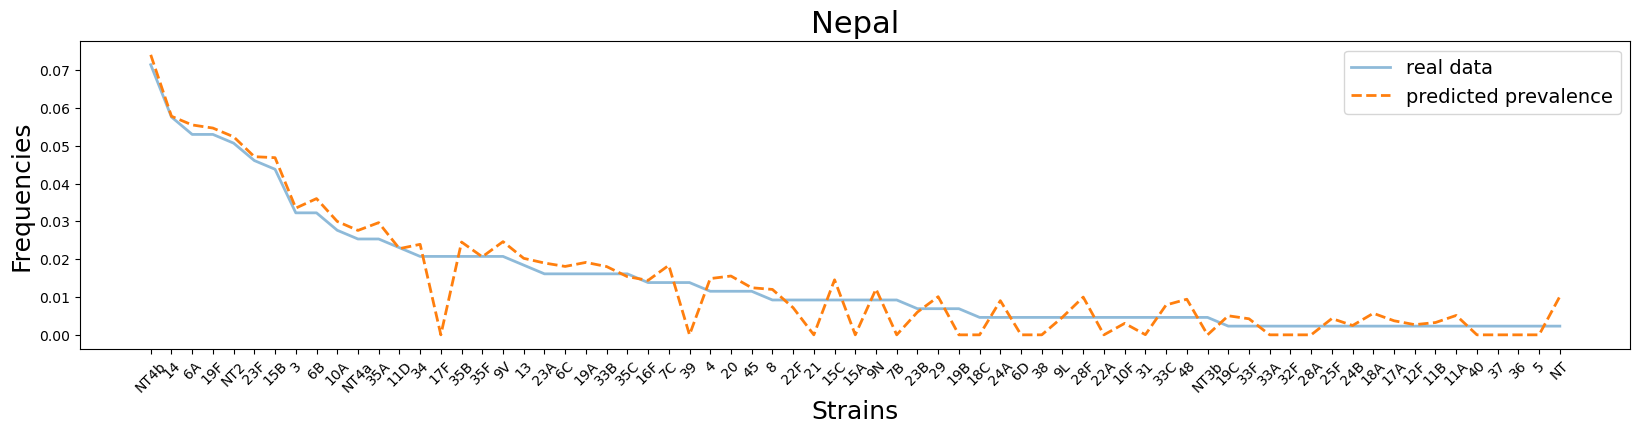

In [11]:
#FINAL TEST by data plot
range_strain = np.linspace(0, strain_number - 1, strain_number)
tick_label = np.array(Nepal.strain)

fig = plt.figure(figsize = (20, 4))
plt.plot(range_strain, Nepal_cases, '-', linewidth = 2, alpha =.5, label = 'real data')
plt.plot(range_strain, solution, '--', linewidth = 2, label = 'predicted prevalence')

plt.xlabel('Strains', fontsize = 18)
plt.ylabel('Frequencies', fontsize = 18)

plt.title('Nepal', fontsize = 22)

plt.xticks(range_strain, labels = tick_label, rotation = 45,)
plt.legend(fontsize = 14)
plt.show()
fig.savefig('Nepal_estimate.png', dpi=300)